In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [109]:
# reading the reduced and cleaned business data
data = pd.read_csv('1_business_cleaned.csv')

In [110]:
data.head(20)

,stars,business_id,name,city,state,postal_code,latitude,longitude,categories,review_count,mean_user_review_counts,mean_months_since_yelping,mean_user_fans,mean_total_compliments
0,4.0,MTSW4McQd7CbVtyjqoe9mw,st honore pastries,philadelphia,PA,19107,39.955505,-75.155564,"restaurants, food, bubble tea, coffee & tea, b...",1.903090,284.183908,123.946723,25.413793,241.045977
1,4.5,mWMc6_wTdE0EUBKIGXDVfA,perkiomen valley brewery,green lane,PA,18054,40.338183,-75.471659,"brewpubs, breweries, food",1.113943,76.571429,102.988832,4.285714,19.071429
2,2.0,CF33F8-E6oudUQ46HnavjQ,sonic drive-in,ashland city,TN,37015,36.269593,-87.058943,"burgers, fast food, sandwiches, food, ice crea...",0.778151,176.000000,97.738218,6.625000,39.125000
3,1.5,bBDDEgkFA1Otx9Lfe7BZUQ,sonic drive-in,nashville,TN,37207,36.208102,-86.768170,"ice cream & frozen yogurt, fast food, burgers,...",1.000000,38.090909,99.420823,6.909091,23.727273
4,2.5,il_Ro8jwPlHresjw9EGmBg,denny's,indianapolis,IN,46227,39.637133,-86.127217,"american (traditional), restaurants, diners, b...",1.447158,46.687500,89.095784,2.625000,27.250000
5,4.0,MUTTqe8uqyMdBl186RmNeA,tuna bar,philadelphia,PA,19106,39.953949,-75.143226,"sushi bars, restaurants, japanese",2.389166,100.196078,98.996056,16.890196,143.729412
6,4.5,ROeacJQwBeh05Rqg7F6TCg,bap,philadelphia,PA,19147,39.943223,-75.162568,"korean, restaurants",2.311754,229.500000,112.914668,25.938679,216.990566
7,4.0,kfNv-JZpuN6TVNSO6hHdkw,hibachi express,indianapolis,IN,46250,39.904320,-86.053080,"steakhouses, asian fusion, restaurants",1.301030,107.409091,74.336730,5.000000,42.818182
8,2.5,9OG5YkX1g2GReZM0AskizA,romano's macaroni grill,reno,NV,89502,39.476117,-119.789339,"restaurants, italian",2.530200,84.516854,107.303138,7.221910,143.988764
9,3.5,sqSqqLy0sN8n2IZrAbzidQ,domino's pizza,white house,TN,37188,36.464747,-86.659187,"pizza, chicken wings, sandwiches, restaurants",0.903090,12.875000,84.323195,0.000000,1.500000


In [112]:
#Feature Extraction

#choosing a few random cuisines for our analysis.

cuisines = [ 'pizza', 'bar', 'mexican', 'american', 'italian', 'indian', 
            'chinese', 'mediterranean']

In [113]:
def applyCuisineData(x):
    for item in cuisines:
        if item in x:
            return item
    else:
        return 'other'

    
data['cuisine'] = data.categories.apply(lambda x: applyCuisineData(x))

In [117]:
# Clustering based on lat/long to identify nearby restaurants.
from sklearn.cluster import DBSCAN

coords = data[['latitude', 'longitude']].values
kms_per_radian = 6371.0088
epsilon = 2 / kms_per_radian
dbscanOutput = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
geoLabels = dbscanOutput.fit_predict(np.radians(coords))
data['location_cluster'] = geoLabels

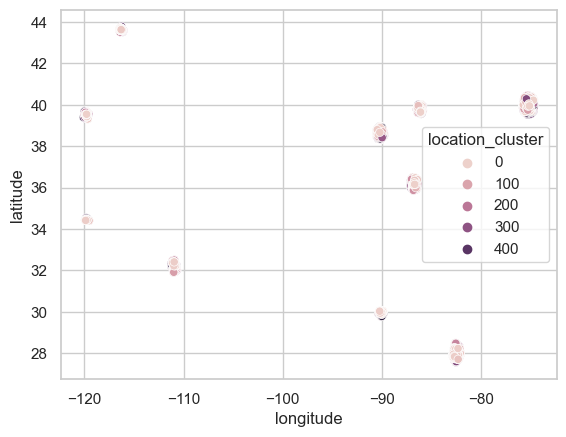

In [122]:
sns_plot = sns.scatterplot(x = "longitude", y = "latitude", hue="location_cluster", data=data)
sns_plot.figure.savefig('geolocation_clusters.png')

## Count of nearby restaurants with similar categories

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

vect = TfidfVectorizer(analyzer='word', stop_words='english')


In [127]:
def similarityCounter(a):
    sims = np.where(a>0.9)
    return len(sims[0])

In [129]:
for cluster in data.location_cluster.unique():
    temp = data[data.location_cluster == cluster]  
    X = vect.fit_transform(temp.categories)
    cosineSimilarity = linear_kernel(X)
    data.loc[data.business_id.isin(temp.business_id), 'sim_counts'] = np.apply_along_axis(similarityCounter, 1, cosineSimilarity)

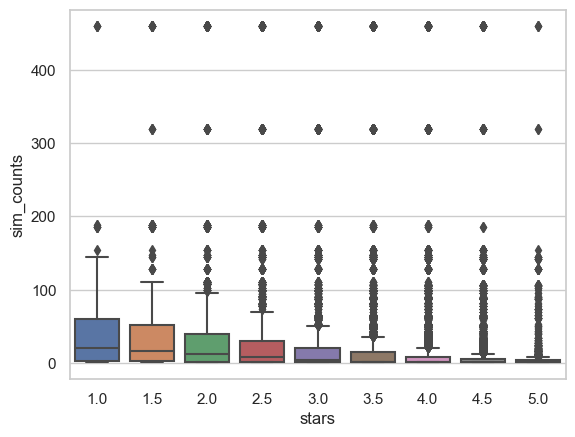

In [131]:
sns_plot = sns.boxplot(x='stars', y='sim_counts', data=data)
sns_plot.figure.savefig('similar_categories_and_stars_boxplot.png')

In [132]:
## Similarity count of closeby restaurants which has same kind of users going to the restaurants.

from sklearn.preprocessing import normalize

for cluster in data.location_cluster.unique():
    temp = data[data.location_cluster == cluster]
    X = normalize(temp[['mean_user_review_counts', 'mean_months_since_yelping', 'mean_user_fans', 'mean_total_compliments']])
    cosineSimilarity = linear_kernel(X)
    data.loc[data.business_id.isin(temp.business_id), 'user_sim_counts'] = np.apply_along_axis(similarityCounter, 1, cosineSimilarity)

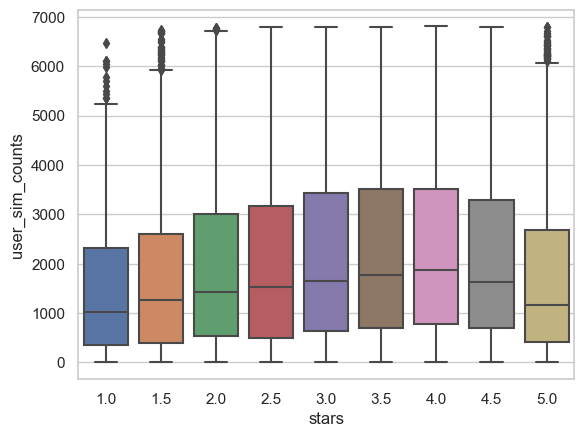

In [136]:
sns_plot = sns.boxplot(x='stars', y='user_sim_counts', data=data)
sns_plot.figure.savefig('similar_users_and_star_snsboxplot.png')

In [140]:
#Splitting category data into different columns.
splitCategoryData = pd.DataFrame(data.categories.str.split(',').tolist(), index = data.business_id).stack()
splitCategoryData = splitCategoryData.reset_index()[[0, 'business_id']]
splitCategoryData.columns = ['category', 'business_id']
splitCategoryData.head()

,category,business_id
0,restaurants,MTSW4McQd7CbVtyjqoe9mw
1,food,MTSW4McQd7CbVtyjqoe9mw
2,bubble tea,MTSW4McQd7CbVtyjqoe9mw
3,coffee & tea,MTSW4McQd7CbVtyjqoe9mw
4,bakeries,MTSW4McQd7CbVtyjqoe9mw


In [143]:
splitCategoryData['present'] = 1
splitCategoryData = splitCategoryData.groupby(['business_id','category'])['present'].mean().unstack(fill_value=0)
splitCategoryData.head()

category,acai bowls,accessories,accountants,active life,acupuncture,adult,adult education,adult entertainment,advertising,afghan,...,wholesalers,wine bars,wine tasting classes,wine tasting room,wine tours,wineries,women's clothing,wraps,yoga,zoos
business_id,,,,,,,,,,,,,,,,,,,,,
---kPU91CF4Lq2-WlRu9Lw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--0iUa4sNDFiZFrAdIWhZQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--SJXpAa0E-GCp2smaHf0A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--epgcb7xHGuJ-4PUeSLAw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--hF_3v1JmU9nlu4zfXJ8Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
splitCategoryData.columns.name = None
splitCategoryData = splitCategoryData.reset_index()
splitCategoryData.head()

,business_id,acai bowls,accessories,accountants,active life,acupuncture,adult,adult education,adult entertainment,advertising,...,wholesalers,wine bars,wine tasting classes,wine tasting room,wine tours,wineries,women's clothing,wraps,yoga,zoos
0,---kPU91CF4Lq2-WlRu9Lw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,--0iUa4sNDFiZFrAdIWhZQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,--SJXpAa0E-GCp2smaHf0A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,--epgcb7xHGuJ-4PUeSLAw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,--hF_3v1JmU9nlu4zfXJ8Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
data = pd.merge(data, splitCategoryData, left_on='business_id', right_on='business_id', how='left')
data = data.drop('categories', axis=1)
data.head()

,stars,business_id,name,city,state,postal_code,latitude,longitude,review_count,mean_user_review_counts,...,wholesalers,wine bars,wine tasting classes,wine tasting room,wine tours,wineries,women's clothing,wraps,yoga,zoos
0,4.0,MTSW4McQd7CbVtyjqoe9mw,st honore pastries,philadelphia,PA,19107,39.955505,-75.155564,1.903090,284.183908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.5,mWMc6_wTdE0EUBKIGXDVfA,perkiomen valley brewery,green lane,PA,18054,40.338183,-75.471659,1.113943,76.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,CF33F8-E6oudUQ46HnavjQ,sonic drive-in,ashland city,TN,37015,36.269593,-87.058943,0.778151,176.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.5,bBDDEgkFA1Otx9Lfe7BZUQ,sonic drive-in,nashville,TN,37207,36.208102,-86.768170,1.000000,38.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.5,il_Ro8jwPlHresjw9EGmBg,denny's,indianapolis,IN,46227,39.637133,-86.127217,1.447158,46.687500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
data = pd.get_dummies(data, columns=['city', 'state', 'postal_code', 'cuisine']) 
data['review_count_bucket'] = pd.qcut(data.review_count, 10)
data.head()

,stars,business_id,name,latitude,longitude,review_count,mean_user_review_counts,mean_months_since_yelping,mean_user_fans,mean_total_compliments,...,cuisine_american,cuisine_bar,cuisine_chinese,cuisine_indian,cuisine_italian,cuisine_mediterranean,cuisine_mexican,cuisine_other,cuisine_pizza,review_count_bucket
0,4.0,MTSW4McQd7CbVtyjqoe9mw,st honore pastries,39.955505,-75.155564,1.903090,284.183908,123.946723,25.413793,241.045977,...,0,0,0,0,0,0,0,1,0,"(1.875, 2.079]"
1,4.5,mWMc6_wTdE0EUBKIGXDVfA,perkiomen valley brewery,40.338183,-75.471659,1.113943,76.571429,102.988832,4.285714,19.071429,...,0,0,0,0,0,0,0,1,0,"(1.041, 1.204]"
2,2.0,CF33F8-E6oudUQ46HnavjQ,sonic drive-in,36.269593,-87.058943,0.778151,176.000000,97.738218,6.625000,39.125000,...,0,0,0,0,0,0,0,1,0,"(0.698, 0.845]"
3,1.5,bBDDEgkFA1Otx9Lfe7BZUQ,sonic drive-in,36.208102,-86.768170,1.000000,38.090909,99.420823,6.909091,23.727273,...,0,0,0,0,0,0,0,1,0,"(0.845, 1.041]"
4,2.5,il_Ro8jwPlHresjw9EGmBg,denny's,39.637133,-86.127217,1.447158,46.687500,89.095784,2.625000,27.250000,...,1,0,0,0,0,0,0,0,0,"(1.362, 1.519]"


In [157]:
data = pd.get_dummies(data, columns=['review_count_bucket'])
data.head()

,stars,business_id,name,latitude,longitude,review_count,mean_user_review_counts,mean_months_since_yelping,mean_user_fans,mean_total_compliments,...,"review_count_bucket_(0.698, 0.845]","review_count_bucket_(0.845, 1.041]","review_count_bucket_(1.041, 1.204]","review_count_bucket_(1.204, 1.362]","review_count_bucket_(1.362, 1.519]","review_count_bucket_(1.519, 1.69]","review_count_bucket_(1.69, 1.875]","review_count_bucket_(1.875, 2.079]","review_count_bucket_(2.079, 2.348]","review_count_bucket_(2.348, 3.879]"
0,4.0,MTSW4McQd7CbVtyjqoe9mw,st honore pastries,39.955505,-75.155564,1.903090,284.183908,123.946723,25.413793,241.045977,...,0,0,0,0,0,0,0,1,0,0
1,4.5,mWMc6_wTdE0EUBKIGXDVfA,perkiomen valley brewery,40.338183,-75.471659,1.113943,76.571429,102.988832,4.285714,19.071429,...,0,0,1,0,0,0,0,0,0,0
2,2.0,CF33F8-E6oudUQ46HnavjQ,sonic drive-in,36.269593,-87.058943,0.778151,176.000000,97.738218,6.625000,39.125000,...,1,0,0,0,0,0,0,0,0,0
3,1.5,bBDDEgkFA1Otx9Lfe7BZUQ,sonic drive-in,36.208102,-86.768170,1.000000,38.090909,99.420823,6.909091,23.727273,...,0,1,0,0,0,0,0,0,0,0
4,2.5,il_Ro8jwPlHresjw9EGmBg,denny's,39.637133,-86.127217,1.447158,46.687500,89.095784,2.625000,27.250000,...,0,0,0,0,1,0,0,0,0,0


In [160]:
#generating new files for the transformed data for further processing.

data.stars = (data.stars * 2).astype(np.int)
data.stars.value_counts()

8     9646
7     7634
9     7366
6     4942
5     3524
4     2565
10    1852
3     1315
2      204
Name: stars, dtype: int64

In [163]:
from scipy.sparse import csr_matrix, save_npz

csrMatrix = csr_matrix(data.drop(['name','business_id','stars'], axis=1).values)
save_npz(matrix=csrMatrix, file='2_Extracted_Data.npz')
data.stars.to_csv('2_Extracted_Data_labels.csv', index=False, header=True)
data.drop(['name','business_id','stars'], axis=1).to_csv('2_Extracted_Data.csv', index=False)